In [1]:
import sys, os
sys.path.insert(0, os.path.dirname(os.path.abspath('..')))

In [2]:
import yaml
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from stochastic_predictors.modules.experiment.metrics import *
from stochastic_predictors.modules.experiment.attacks import *
from stochastic_predictors.modules.model.cnn import StochasticCNN

In [4]:
import torch
from torch import nn, optim
import torchvision.transforms as transforms

from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

In [5]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_dataset = FashionMNIST("../data", download=True, train=True, transform=transforms)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = FashionMNIST("../data", download=False, train=False, transform=transforms)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [6]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print("Using device:", dev)

# load experiment configuration file
with open("../experiments/exp-b04/config-b04.yaml") as config:
    params = dict(yaml.load(config, Loader=yaml.FullLoader))

# load model
net = StochasticCNN(params["model"], params["n_for_features"], params["batch_norm"])

Using device: cuda


100%|██████████| 18/18 [00:00<00:00, 2124.48it/s]


In [7]:
net.train()
net.to(dev)

StochasticCNN(
  (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(12, 12, kernel_size=(2, 2), stride=(2, 2))
  (7): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
  (12): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): Conv2d(48, 48, kernel_size=(2, 2), stride=(2, 2))
  (15): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1))
  (17

In [8]:
history = {
    key: list() for key in ["train_obj", "val_obj", "train_acc", "val_acc"]
}

In [9]:
optimizer = optim.Adam(net.parameters(), lr=1e-4)
loss = nn.CrossEntropyLoss(reduction="none")

In [10]:
from torchattacks import FGSM

In [11]:
atk = FGSM(net, eps=0.005)

In [12]:
softmax = nn.Softmax(dim=1)
for epoch in range(100):
    print(f'Epoch: {epoch + 1} / {100}')
    train_obj = 0
    train_acc = 0
    n_data = 0

    net.train()
    for i, (data, target) in enumerate(train_loader):
        data = atk(data, target).to(dev)
        target = target.to(dev)
        y = softmax(net.forward(data))
        l = loss(y, target)
        train_obj += l.sum().item()

        pred = torch.argmax(y, dim=1)
        train_acc += torch.sum(target == pred)
        n_data += data.size(0)

        optimizer.zero_grad()
        l.mean().backward()
        optimizer.step()
    train_obj /= n_data
    train_acc = float(train_acc) / n_data

    if val_loader is not None:
        val_obj = 0
        val_acc = 0
        n_data = 0
        net.eval()
        for i, (data, target) in enumerate(val_loader):
            data = data.to(dev)
            target = target.to(dev)
            y = softmax(net.forward(data))
            l = loss(y, target)
            val_obj += l.sum().item()
            pred = torch.argmax(y, dim=1)
            val_acc += torch.sum(target == pred)

            n_data += data.size(0)
        val_obj /= n_data
        val_acc = float(val_acc) / n_data

    print(f"\ttrain loss: {train_obj}, val loss: {val_obj}")
    print(f"\ttrain accuracy {train_acc}, val accuracy: {val_acc}")
    history["train_obj"].append(train_obj)
    history["val_obj"].append(val_obj)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    if epoch % 25 == 0 and epoch > 0:
        print("saving model checkpoint...")
        j = epoch // 25
        torch.save(net.state_dict(),
                   os.path.join("/home/solia/Documents/stochastic_predictors/experiments/exp-b06",
                   "baseline-adversarial" + "-checkpoint" + str(j) + ".pt"))
        atk = FGSM(net, eps=0.005)

print("\nsaving history...")
history_file_p = os.path.join("/home/solia/Documents/stochastic_predictors/experiments/exp-b06",
                "baseline-adversarial" + "06" + "-history.pickle")
with open(history_file_p, 'wb') as history_file:
    pickle.dump(history, history_file, protocol=pickle.HIGHEST_PROTOCOL)


Epoch: 1 / 100
	train loss: 1.9968994027455649, val loss: 2.0044271522521973
	train accuracy 0.63655, val accuracy: 0.4748
Epoch: 2 / 100
	train loss: 1.8692556037902832, val loss: 1.9975205463409424
	train accuracy 0.7668, val accuracy: 0.4804
Epoch: 3 / 100
	train loss: 1.816210550181071, val loss: 1.9509641735076904
	train accuracy 0.7986833333333333, val accuracy: 0.516
Epoch: 4 / 100
	train loss: 1.7781397764205933, val loss: 1.940529877090454
	train accuracy 0.8174833333333333, val accuracy: 0.5241
Epoch: 5 / 100
	train loss: 1.745952007039388, val loss: 1.974429902076721
	train accuracy 0.83185, val accuracy: 0.4872
Epoch: 6 / 100
	train loss: 1.722718989054362, val loss: 1.953197012901306
	train accuracy 0.84015, val accuracy: 0.5081
Epoch: 7 / 100
	train loss: 1.7005228888829549, val loss: 1.9340782049179077
	train accuracy 0.8502666666666666, val accuracy: 0.5265
Epoch: 8 / 100
	train loss: 1.6847127026240032, val loss: 1.9335372650146485
	train accuracy 0.8564833333333334, v

	train loss: 1.5148572945276897, val loss: 1.9387126625061035
	train accuracy 0.9524666666666667, val accuracy: 0.5213
Epoch: 65 / 100
	train loss: 1.5135841869354247, val loss: 1.9099799997329712
	train accuracy 0.9533333333333334, val accuracy: 0.5493
Epoch: 66 / 100
	train loss: 1.513214180246989, val loss: 1.9173037818908691
	train accuracy 0.9538, val accuracy: 0.5428
Epoch: 67 / 100
	train loss: 1.511957479095459, val loss: 1.8898064102172851
	train accuracy 0.9549333333333333, val accuracy: 0.5709
Epoch: 68 / 100
	train loss: 1.5126059402465821, val loss: 1.89712621383667
	train accuracy 0.9539333333333333, val accuracy: 0.5636
Epoch: 69 / 100
	train loss: 1.5120945596694946, val loss: 1.912681008529663
	train accuracy 0.9542, val accuracy: 0.5479
Epoch: 70 / 100
	train loss: 1.5114804358800251, val loss: 1.923213600921631
	train accuracy 0.9548333333333333, val accuracy: 0.537
Epoch: 71 / 100
	train loss: 1.5101761950174968, val loss: 1.9019255241394042
	train accuracy 0.956033

In [13]:
net.cpu()

StochasticCNN(
  (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(12, 12, kernel_size=(2, 2), stride=(2, 2))
  (7): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
  (12): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): Conv2d(48, 48, kernel_size=(2, 2), stride=(2, 2))
  (15): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1))
  (17

In [14]:
test_loader = DataLoader(val_dataset, batch_size=5000, shuffle=True)

In [15]:
for p in [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]:
    d = nn.Dropout(p=p)
    for data, target in test_loader:
        y = softmax(net.forward(d(data)))
        pred = torch.argmax(y, dim=1)
        acc = (pred == target).sum() / target.size(0)
    print(p, acc)

0.001 tensor(0.5394)
0.005 tensor(0.5290)
0.01 tensor(0.5268)
0.02 tensor(0.5280)
0.05 tensor(0.5160)
0.1 tensor(0.4820)
0.2 tensor(0.4086)
0.5 tensor(0.2074)


In [16]:
for e in [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]:
    atk = FGSM(net, eps=e)
    for data, target in test_loader:
        y = softmax(net.forward(atk(data, target)))
        pred = torch.argmax(y, dim=1)
        acc = (pred == target).sum() / target.size(0)
    print(e, acc)

0.5 tensor(0.8612)
0.5 tensor(0.8626)
0.5 tensor(0.8600)
0.5 tensor(0.8606)
0.5 tensor(0.8580)
0.5 tensor(0.8702)
0.5 tensor(0.8554)
0.5 tensor(0.8196)
0.5 tensor(0.7828)


In [18]:
from torchattacks import BIM

In [19]:
for e in [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]:
    atk = BIM(net, eps=e)
    for data, target in test_loader:
        y = softmax(net.forward(atk(data, target)))
        pred = torch.argmax(y, dim=1)
        acc = (pred == target).sum() / target.size(0)
    print(e, acc)

1e-05 tensor(0.5426)
5e-05 tensor(0.5464)
0.0001 tensor(0.5356)
0.0005 tensor(0.5378)
0.001 tensor(0.5426)
0.005 tensor(0.5220)
0.01 tensor(0.5140)
0.05 tensor(0.4340)
0.1 tensor(0.3550)


In [24]:
for data, target in test_loader:
    y = softmax(net.forward(data))
    pred = torch.argmax(y, dim=1)
    y_pred, _ = torch.max(y, dim=1)
    y_corr, _ = torch.max(y[target == pred], dim=1)
    y_wrong, _ = torch.max(y[target != pred][:, pred], dim=1)

In [25]:
y = y_pred.detach().cpu()
y_corr = y_corr.detach().cpu()
y_wrong = y_wrong.detach().cpu()

In [26]:
y_corr = torch.round(y_corr * 10).numpy()
y_wrong = torch.round(y_wrong * 10).numpy()

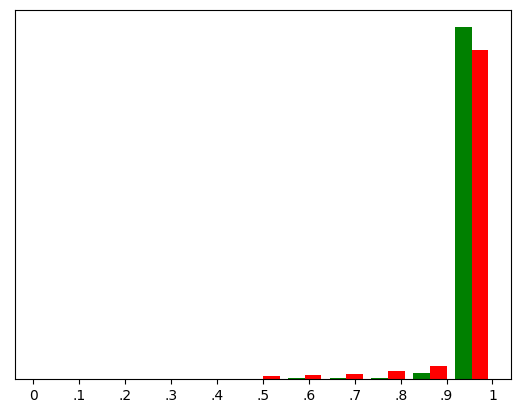

In [27]:
plt.hist([y_corr, y_wrong], bins=11, range=(0, 10), density=True, color=["green", "red"])
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
           labels=['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8', '.9', '1'])
plt.yticks([])
plt.show()